# Covid-19-Trend-Predictor
#### Prediction of number of Covid-19 cases in India for the next 15 days using LSTM
[Github-Repository](https://github.com/abdulsmapara/Covid-19-Trend-Predictor)


In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import rmse
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import tensorflow as tf
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


#### Preparing data
1. Features are scaled in suitable range
2. Data prepared for different countries differently (to prepare time-series indexed by date for each)

In [2]:
# data
df = pd.read_csv('../Timeseries-Data/timeseries_data.csv')
columns_to_keep = ['Date','Index','Location','Population_Density','Min_Temp','Max_Temp','Lockdown','Num_Cases']
df = df.astype({"Population_Density":float ,"Lockdown": float,'Num_Cases':float})
df = df[columns_to_keep]
numeric_columns = ['Population_Density','Lockdown','Max_Temp','Min_Temp','Num_Cases']
df_numeric = df[numeric_columns]
df_temp = df[['Min_Temp','Max_Temp']]
final_temp = []
df_numeric.head()
print('Min', np.min(df_numeric))
print('Max', np.max(df_numeric))
dataset = df_numeric.astype('float64')
# scaling
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
scaled_data = scaler.fit_transform(dataset)
temp_deno = (np.max(df['Max_Temp']) - np.min(df['Min_Temp']))
temp_num = np.min(df['Min_Temp'])
for ind in df['Index']:
    index = int(ind)
    df.at[index,'Population_Density'] = scaled_data[index][0]
    df.at[index,'Lockdown'] = scaled_data[index][1]
    df.at[index,'Min_Temp'] = (df.at[index,'Min_Temp'] - temp_num)/ temp_deno
    df.at[index,'Max_Temp'] = (df.at[index,'Max_Temp'] - temp_num)/ temp_deno
df = df.set_index("Date")
df_final = []
df_final.append(df[df.Location=='Australia'].reset_index(drop=True))
df_final.append(df[df.Location == 'India'].reset_index(drop=True))
df_final.append(df[df.Location == 'China'].reset_index(drop=True))
df_final.append(df[df.Location == 'USA'].reset_index(drop=True))
df_final.append(df[df.Location == 'Italy'].reset_index(drop=True))
df_final.append(df[df.Location == 'France'].reset_index(drop=True))

for df_temp in df_final:
    i=0
    for ind in df_temp['Index']:
        df_temp.at[i,'Index'] = i
        i+=1
    for ind in reversed(df_temp['Index']):
        i = int(ind)
        if i != 0:
            df_temp.at[i,'Num_Cases'] -= df_temp.at[i-1,'Num_Cases']
    print(np.max(df_temp['Num_Cases']))
    df_temp['Num_Cases'] /= 1500

df_final[1]

Min Population_Density    9.0
Lockdown              0.0
Max_Temp              5.0
Min_Temp             -8.0
Num_Cases             0.0
dtype: float64
Max Population_Density      1202.0
Lockdown                 100.0
Max_Temp                  40.0
Min_Temp                  26.0
Num_Cases             187321.0
dtype: float64
573.0
309.0
15133.0
24126.0
6557.0
7578.0


,Index,Location,Population_Density,Min_Temp,Max_Temp,Lockdown,Num_Cases
0,0.0,India,1.0,0.479167,0.645833,0.0,0.000000
1,1.0,India,1.0,0.437500,0.583333,0.0,0.000000
2,2.0,India,1.0,0.416667,0.625000,0.0,0.000000
3,3.0,India,1.0,0.500000,0.625000,0.0,0.000000
4,4.0,India,1.0,0.458333,0.645833,0.0,0.000000
5,5.0,India,1.0,0.458333,0.645833,0.0,0.000000
6,6.0,India,1.0,0.479167,0.562500,0.0,0.000000
7,7.0,India,1.0,0.458333,0.625000,0.0,0.000000
8,8.0,India,1.0,0.458333,0.604167,0.0,0.000667
9,9.0,India,1.0,0.479167,0.604167,0.0,0.000000


In [3]:
columns_input = ['Population_Density','Min_Temp','Max_Temp','Lockdown','Num_Cases']

for i in range(len(df_final)):
    df_final[i] = df_final[i][columns_input]

In [4]:
# df_India=df_India.set_index('Date')
columns_input = ['Population_Density','Min_Temp','Max_Temp','Lockdown','Num_Cases']
# input_data = df_India[columns_input]
# output_data = df_India['Num_Cases']
# X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size = 0.304761, random_state = 1)
from pandas import DataFrame
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
df_India = df_final[1][columns_input]
df_India = series_to_supervised(df_India,7,1,True)
# new_df.drop(new_df.columns[[-2,-3,-4,-5]], axis=1, inplace=True)

df_China = series_to_supervised(df_final[2],7,1,True)
df_Australia = series_to_supervised(df_final[0],7,1,True)
df_USA= series_to_supervised(df_final[3],7,1,True)
df_Italy=series_to_supervised(df_final[4],7,1,True)
df_France=series_to_supervised(df_final[5],7,1,True)
df_India

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
7,1.0,0.479167,0.645833,0.0,0.000000,1.0,0.437500,0.583333,0.0,0.000000,...,1.0,0.479167,0.562500,0.0,0.000000,1.0,0.458333,0.625000,0.0,0.000000
8,1.0,0.437500,0.583333,0.0,0.000000,1.0,0.416667,0.625000,0.0,0.000000,...,1.0,0.458333,0.625000,0.0,0.000000,1.0,0.458333,0.604167,0.0,0.000667
9,1.0,0.416667,0.625000,0.0,0.000000,1.0,0.500000,0.625000,0.0,0.000000,...,1.0,0.458333,0.604167,0.0,0.000667,1.0,0.479167,0.604167,0.0,0.000000
10,1.0,0.500000,0.625000,0.0,0.000000,1.0,0.458333,0.645833,0.0,0.000000,...,1.0,0.479167,0.604167,0.0,0.000000,1.0,0.458333,0.604167,0.0,0.000000
11,1.0,0.458333,0.645833,0.0,0.000000,1.0,0.458333,0.645833,0.0,0.000000,...,1.0,0.458333,0.604167,0.0,0.000000,1.0,0.479167,0.645833,0.0,0.000667
12,1.0,0.458333,0.645833,0.0,0.000000,1.0,0.479167,0.562500,0.0,0.000000,...,1.0,0.479167,0.645833,0.0,0.000667,1.0,0.479167,0.687500,0.0,0.000667
13,1.0,0.479167,0.562500,0.0,0.000000,1.0,0.458333,0.625000,0.0,0.000000,...,1.0,0.479167,0.687500,0.0,0.000667,1.0,0.500000,0.625000,0.0,0.000000
14,1.0,0.458333,0.625000,0.0,0.000000,1.0,0.458333,0.604167,0.0,0.000667,...,1.0,0.500000,0.625000,0.0,0.000000,1.0,0.458333,0.645833,0.0,0.000000
15,1.0,0.458333,0.604167,0.0,0.000667,1.0,0.479167,0.604167,0.0,0.000000,...,1.0,0.458333,0.645833,0.0,0.000000,1.0,0.479167,0.666667,0.0,0.000000
16,1.0,0.479167,0.604167,0.0,0.000000,1.0,0.458333,0.604167,0.0,0.000000,...,1.0,0.479167,0.666667,0.0,0.000000,1.0,0.458333,0.625000,0.0,0.000000


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 55)                20900     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 56        
Total params: 20,956
Trainable params: 20,956
Non-trainable params: 0
_________________________________________________________________
Train on 61 samples, validate on 2 samples
Epoch 1/93
 - 0s - loss: 0.0415 - val_loss: 0.1819
Epoch 2/93
 - 0s - loss: 0.0224 - val_loss: 0.1212
Epoch 3/93
 - 0s - loss: 0.0120 - val_loss: 0.0757
Epoch 4/93
 - 0s - loss: 0.0088 - val_loss: 0.0450
Epoch 5/93
 - 0s - loss: 0.0097 - val_loss: 0.0265
Epoch 6/93
 - 0s - loss: 0.0114 - val_loss: 0.0164
Epoch 7/93
 - 0s - loss: 0.0117 - val_loss: 0.0112
Epoch 8/93
 - 0s - loss: 0.0105 - val_loss: 0.0085
Epoch 9/93
 - 0s - loss: 0.0085 - val_loss: 0.0071
Epoch 10/

Epoch 52/93
 - 0s - loss: 1.1509 - val_loss: 0.0436
Epoch 53/93
 - 0s - loss: 1.1444 - val_loss: 0.0448
Epoch 54/93
 - 0s - loss: 1.1379 - val_loss: 0.0454
Epoch 55/93
 - 0s - loss: 1.1314 - val_loss: 0.0460
Epoch 56/93
 - 0s - loss: 1.1249 - val_loss: 0.0471
Epoch 57/93
 - 0s - loss: 1.1183 - val_loss: 0.0484
Epoch 58/93
 - 0s - loss: 1.1117 - val_loss: 0.0497
Epoch 59/93
 - 0s - loss: 1.1050 - val_loss: 0.0510
Epoch 60/93
 - 0s - loss: 1.0983 - val_loss: 0.0523
Epoch 61/93
 - 0s - loss: 1.0915 - val_loss: 0.0538
Epoch 62/93
 - 0s - loss: 1.0846 - val_loss: 0.0551
Epoch 63/93
 - 0s - loss: 1.0777 - val_loss: 0.0562
Epoch 64/93
 - 0s - loss: 1.0708 - val_loss: 0.0575
Epoch 65/93
 - 0s - loss: 1.0638 - val_loss: 0.0589
Epoch 66/93
 - 0s - loss: 1.0567 - val_loss: 0.0602
Epoch 67/93
 - 0s - loss: 1.0495 - val_loss: 0.0614
Epoch 68/93
 - 0s - loss: 1.0423 - val_loss: 0.0626
Epoch 69/93
 - 0s - loss: 1.0349 - val_loss: 0.0638
Epoch 70/93
 - 0s - loss: 1.0275 - val_loss: 0.0652
Epoch 71/93


Epoch 22/93
 - 0s - loss: 0.4540 - val_loss: 11.3619
Epoch 23/93
 - 0s - loss: 0.4330 - val_loss: 11.3303
Epoch 24/93
 - 0s - loss: 0.4127 - val_loss: 11.1736
Epoch 25/93
 - 0s - loss: 0.3902 - val_loss: 10.9144
Epoch 26/93
 - 0s - loss: 0.3665 - val_loss: 10.5847
Epoch 27/93
 - 0s - loss: 0.3439 - val_loss: 10.2156
Epoch 28/93
 - 0s - loss: 0.3241 - val_loss: 9.8333
Epoch 29/93
 - 0s - loss: 0.3065 - val_loss: 9.4576
Epoch 30/93
 - 0s - loss: 0.2900 - val_loss: 9.1024
Epoch 31/93
 - 0s - loss: 0.2742 - val_loss: 8.7771
Epoch 32/93
 - 0s - loss: 0.2593 - val_loss: 8.4872
Epoch 33/93
 - 0s - loss: 0.2459 - val_loss: 8.2333
Epoch 34/93
 - 0s - loss: 0.2347 - val_loss: 8.0100
Epoch 35/93
 - 0s - loss: 0.2253 - val_loss: 7.8033
Epoch 36/93
 - 0s - loss: 0.2166 - val_loss: 7.5962
Epoch 37/93
 - 0s - loss: 0.2080 - val_loss: 7.3790
Epoch 38/93
 - 0s - loss: 0.2002 - val_loss: 7.1523
Epoch 39/93
 - 0s - loss: 0.1932 - val_loss: 6.9233
Epoch 40/93
 - 0s - loss: 0.1870 - val_loss: 6.7013
Epoch 

Epoch 86/93
 - 0s - loss: 0.1002 - val_loss: 1.4730
Epoch 87/93
 - 0s - loss: 0.0997 - val_loss: 1.4711
Epoch 88/93
 - 0s - loss: 0.0992 - val_loss: 1.4693
Epoch 89/93
 - 0s - loss: 0.0987 - val_loss: 1.4676
Epoch 90/93
 - 0s - loss: 0.0982 - val_loss: 1.4660
Epoch 91/93
 - 0s - loss: 0.0978 - val_loss: 1.4644
Epoch 92/93
 - 0s - loss: 0.0973 - val_loss: 1.4628
Epoch 93/93
 - 0s - loss: 0.0968 - val_loss: 1.4613
Train on 61 samples, validate on 2 samples
Epoch 1/93
 - 0s - loss: 0.0320 - val_loss: 0.0281
Epoch 2/93
 - 0s - loss: 0.0138 - val_loss: 0.0669
Epoch 3/93
 - 0s - loss: 0.0037 - val_loss: 0.1178
Epoch 4/93
 - 0s - loss: 0.0094 - val_loss: 0.1465
Epoch 5/93
 - 0s - loss: 0.0152 - val_loss: 0.1336
Epoch 6/93
 - 0s - loss: 0.0111 - val_loss: 0.0947
Epoch 7/93
 - 0s - loss: 0.0045 - val_loss: 0.0572
Epoch 8/93
 - 0s - loss: 0.0037 - val_loss: 0.0353
Epoch 9/93
 - 0s - loss: 0.0065 - val_loss: 0.0284
Epoch 10/93
 - 0s - loss: 0.0067 - val_loss: 0.0322
Epoch 11/93
 - 0s - loss: 0.00

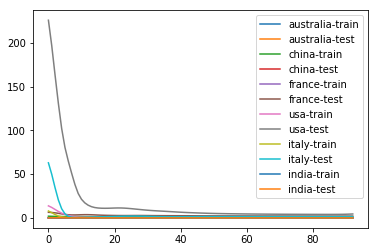

In [35]:
from numpy import concatenate
split_train = 61
values = df_Australia.values
train = values[:split_train,:]
test = values[split_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
model = Sequential()
model.add(LSTM(55, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
num_epochs = 93
# fit network
batch_size=None
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='australia-train')
plt.plot(history.history['val_loss'], label='australia-test')

# # fit network
values = df_China.values
train = values[:split_train,:]
test = values[split_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, validation_data=(test_X, test_y),verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='china-train')
plt.plot(history.history['val_loss'], label='china-test')

# # fit network
values = df_France.values
train = values[:split_train,:]
test = values[split_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, validation_data=(test_X, test_y),verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='france-train')
plt.plot(history.history['val_loss'], label='france-test')

# # fit network
values = df_USA.values
train = values[:split_train,:]
test = values[split_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, validation_data=(test_X, test_y),verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='usa-train')
plt.plot(history.history['val_loss'], label='usa-test')

# # fit network
values = df_Italy.values
train = values[:split_train,:]
test = values[split_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, validation_data=(test_X, test_y),verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='italy-train')
plt.plot(history.history['val_loss'], label='italy-test')

# # fit network
values = df_India.values
train = values[:split_train,:]
test = values[split_train:,:]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, validation_data=(test_X, test_y),verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='india-train')
plt.plot(history.history['val_loss'], label='india-test')
plt.legend()
plt.show()



In [39]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pandas import DataFrame

def is_correct(value1, value2):
    correctness = False
    if value1 == value2:
        correctness = True
    elif abs(value1 - value2) <= 5:
        correctness = True
    elif value2 != 0 and value1/value2 <= 1.5 and value1/value2 >= (5/8):
        correctness = True
    return correctness

y_pred = model.predict(train_X, batch_size=batch_size)
i = 0

comparision_data = DataFrame()
correct = 0
total = 0
for x,y,actual in zip(train_X, y_pred,train_y):
    comparision_data.at[i,'Day']=i
    if y[0] < 0.0:
        y[0] = 0.0
    comparision_data.at[i,'Predicted'] = round(y[0]*1500)
    comparision_data.at[i,'Actual'] = (actual*1500)
    comparision_data.at[i,'State'] = 'Incorrect'
    if  is_correct(comparision_data.at[i,'Predicted'], comparision_data.at[i,'Actual']):
        correct+=1
        comparision_data.at[i,'State'] = 'Correct'
    total+=1
    i+=1

print(comparision_data)
print(correct/total)
plt.figure(figsize=(20,10))
#plt.plot(scaler.inverse_transform(scaled))
plt.plot(comparision_data['Actual'],label='actual')
plt.plot(comparision_data['Predicted'],label='predicted')
plt.legend()
plt.show()

In [138]:
# Test for April 1-15
df_test = pd.read_csv('../Timeseries-Data/test_data.csv')
columns_to_keep = ['Date','Population_Density','Min_Temp','Max_Temp','Lockdown','Num_Cases']
df_test = df_test.astype({"Population_Density":float ,"Lockdown": float,'Num_Cases':float,'Min_Temp':float,'Max_Temp':float})
df_test = df_test[columns_to_keep]

i=0
prev = 0.0
for ind in reversed(df_test.index):
    df_test.at[ind,'Min_Temp'] = (df_test.at[ind,'Min_Temp'] - temp_num)/temp_deno
    df_test.at[ind,'Max_Temp'] = (df_test.at[ind,'Max_Temp'] - temp_num)/temp_deno
    df_test.at[ind,'Lockdown'] /= 100
    if ind != 0:
        df_test.at[ind,'Num_Cases'] -= df_test.at[ind-1,'Num_Cases']

df_test.at[0,'Num_Cases'] = 86
df_test['Num_Cases'] /= 500

df_test = df_test.set_index('Date')

df_test

,Population_Density,Min_Temp,Max_Temp,Lockdown,Num_Cases
Date,,,,,
3/25/2020,1.0,0.687500,0.875000,1.0,0.172
3/26/2020,1.0,0.687500,0.833333,1.0,0.146
3/27/2020,1.0,0.625000,0.708333,1.0,0.306
3/28/2020,1.0,0.625000,0.833333,1.0,0.272
3/29/2020,1.0,0.687500,0.833333,1.0,0.240
3/30/2020,1.0,0.687500,0.833333,1.0,0.374
3/31/2020,1.0,0.666667,0.854167,1.0,0.618
4/1/2020,1.0,0.687500,0.916667,1.0,-3.270
4/2/2020,1.0,0.687500,0.854167,1.0,0.000


PREDICTION FOR 1st April to 15th April (Unseen data for model)

         Day  Predicted  Actual                    State
0    1 April      350.0   424.0  Within the range of 100
1    2 April      562.0   486.0  Within the range of 100
2    3 April      585.0   560.0  Within the range of 100
3    4 April      560.0   579.0  Within the range of 100
4    5 April      635.0   605.0  Within the range of 100
5    6 April      713.0   489.0      Too far from actual
6    7 April      626.0   573.0  Within the range of 100
7    8 April      665.0   565.0  Within the range of 100
8    9 April      724.0   813.0  Within the range of 100
9   10 April      741.0   871.0      Too far from actual
10  11 April      825.0   854.0  Within the range of 100
11  12 April      848.0   751.0  Within the range of 100
12  13 April      884.0   961.0  Within the range of 100
13  14 April      921.0   834.0  Within the range of 100
14  15 April     1020.0  1000.0  Within the range of 100
87 %
RMSE =  91.32068038876335


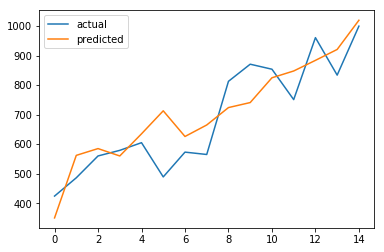

In [139]:
from sklearn.metrics import mean_squared_error
import math

i = 0
comparision_data = DataFrame()
correct = 0
total = 0
df_actual = pd.read_csv("../Timeseries-Data/test_data.csv", index_col='Date')


def is_correct(value1, value2):
    correctness = False
    if value1 == value2:
        correctness = True
    elif abs(value1 - value2) <= 100:
        correctness = True
    return correctness

df_actual = df_actual['3/31/2020':]
prev_date = '3/31/2020'
for _ in range(15):
    current_date = '4/'+str(i+1)+'/2020'
    actual = df_actual.at[current_date,'Actual_Num_Cases'] - df_actual.at[prev_date,'Actual_Num_Cases']
    prev_date = current_date
    df_partial = df_test['3/25/2020':current_date]
    df_partial_timeseries = series_to_supervised(df_partial,7,1,True)
    values = df_partial_timeseries.values
    test_x = values[-1:,:-1]
    test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
    y_pred = model.predict(test_X, batch_size=batch_size)
    y = y_pred[0]
    x = test_X[0]
    comparision_data.at[i,'Day']=str(i+1)+' April'
    if y[0] < 0.0:
        y[0] = 0.0
    comparision_data.at[i,'Predicted'] = round(y[0]*1500)
    comparision_data.at[i,'Actual'] = actual
    comparision_data.at[i,'State'] = 'Too far from actual'
    if is_correct(comparision_data.at[i,'Predicted'],comparision_data.at[i,'Actual']):
        correct+=1
        comparision_data.at[i,'State'] = 'Within the range of 100'
    total+=1
    df_test.at['4/'+str(i+1)+'/2020', 'Num_Cases'] = y[0]
    i+=1

print(comparision_data)
print(round((correct/total)*100),"%")
rmse = math.sqrt(mean_squared_error(comparision_data['Actual'], comparision_data['Predicted']))
print("RMSE = ", rmse)
# plt.figure(figsize=(5,5))
#plt.plot(scaler.inverse_transform(scaled))
plt.plot(comparision_data['Actual'],label='actual')
plt.plot(comparision_data['Predicted'],label='predicted')
plt.legend()
plt.show()

Without LOCKDOWN, 16th April to 30th April (using predicted values not actual of 1st April-15th April)

         Day  Predicted
15  16 April      942.0
16  17 April     1201.0
17  18 April     1317.0
18  19 April     1557.0
19  20 April     1435.0
20  21 April     1534.0
21  22 April     1783.0
22  23 April     2307.0
23  24 April     2601.0
24  25 April     3050.0
25  26 April     3430.0
26  27 April     3965.0
27  28 April     4425.0
28  29 April     4708.0
29  30 April     4867.0


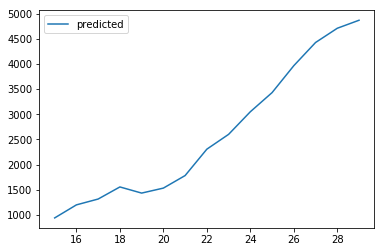

In [137]:
i = 15
prediction = DataFrame()


prev_date = '4/15/2020'
for _ in range(15):
    current_date = '4/'+str(i+1)+'/2020'
    prev_date = current_date
    df_partial = df_test['4/9/2020':current_date]
    df_partial_timeseries = series_to_supervised(df_partial,7,1,True)
    values = df_partial_timeseries.values
    test_x = values[-1:,:-1]
    test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
    y_pred = model.predict(test_X, batch_size=batch_size)
    y = y_pred[0]
    x = test_X[0]
    prediction.at[i,'Day']=str(i+1)+' April'
    if y[0] < 0.0:
        y[0] = 0.0
    prediction.at[i,'Predicted'] = round(y[0]*1500)
    df_test.at['4/'+str(i+1)+'/2020', 'Num_Cases'] = y[0]
    i+=1

print(prediction)
# plt.figure(figsize=(5,5))
#plt.plot(scaler.inverse_transform(scaled))

plt.plot(prediction['Predicted'],label='predicted')
plt.legend()
plt.show()

With Lockdown, 16th April to 30th April (using predicted values not actual of 1st April-15th April)

         Day  Predicted
15  16 April     1031.0
16  17 April     1111.0
17  18 April     1153.0
18  19 April     1256.0
19  20 April     1233.0
20  21 April     1301.0
21  22 April     1369.0
22  23 April     1538.0
23  24 April     1642.0
24  25 April     1745.0
25  26 April     1815.0
26  27 April     1978.0
27  28 April     2165.0
28  29 April     2378.0
29  30 April     2604.0


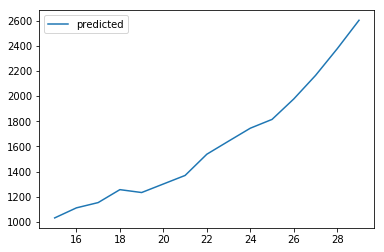

In [140]:
i = 15
prediction = DataFrame()
def is_correct(value1, value2):
    correctness = False
    if value1 == value2:
        correctness = True
    elif abs(value1 - value2) <= 100:
        correctness = True
    return correctness

df_actual = df_actual['4/15/2020':]
prev_date = '4/15/2020'
for _ in range(15):
    current_date = '4/'+str(i+1)+'/2020'
    prev_date = current_date
    df_partial = df_test['4/9/2020':current_date]
    df_partial_timeseries = series_to_supervised(df_partial,7,1,True)
    values = df_partial_timeseries.values
    test_x = values[-1:,:-1]
    test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
    y_pred = model.predict(test_X, batch_size=batch_size)
    y = y_pred[0]
    x = test_X[0]
    prediction.at[i,'Day']=str(i+1)+' April'
    if y[0] < 0.0:
        y[0] = 0.0
    prediction.at[i,'Predicted'] = round(y[0]*1500)
    df_test.at['4/'+str(i+1)+'/2020', 'Num_Cases'] = y[0]
    i+=1

print(prediction)
# plt.figure(figsize=(5,5))
#plt.plot(scaler.inverse_transform(scaled))
plt.plot(prediction['Predicted'],label='predicted')
plt.legend()
plt.show()